ATML & EC Mini Project

Topic: EvoAuto - Evolving Autoencoders for Anomaly Detection

Name: Aditya Singh & Sannidhi Nair

Roll No: I005 & I056

Credit Card Fraud Detection Dataset: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

# Loading & Preprocessing Credit Card Fraud Detection Dataset

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


df = pd.read_csv('/creditcard.csv')


X = df.drop(columns=['Time', 'Class'])
y = df['Class']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


X_train = X_train[y_train == 0]

# Autoencoder

In [ ]:
import numpy as np


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))


def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


class Autoencoder:
    def __init__(self, input_size, hidden_size, bottleneck_size, learning_rate=0.01):
        self.lr = learning_rate


        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))

        self.W2 = np.random.randn(hidden_size, bottleneck_size) * 0.01
        self.b2 = np.zeros((1, bottleneck_size))

        self.W3 = np.random.randn(bottleneck_size, hidden_size) * 0.01
        self.b3 = np.zeros((1, hidden_size))

        self.W4 = np.random.randn(hidden_size, input_size) * 0.01
        self.b4 = np.zeros((1, input_size))

    def forward(self, X):

        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = sigmoid(self.z1)

        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = sigmoid(self.z2)


        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = sigmoid(self.z3)

        self.z4 = np.dot(self.a3, self.W4) + self.b4
        self.output = sigmoid(self.z4)

        return self.output

    def backward(self, X):
        m = X.shape[0]
        error = self.output - X
        d_output = error * sigmoid_derivative(self.z4)

        dW4 = np.dot(self.a3.T, d_output) / m
        db4 = np.sum(d_output, axis=0, keepdims=True) / m

        d_a3 = np.dot(d_output, self.W4.T) * sigmoid_derivative(self.z3)
        dW3 = np.dot(self.a2.T, d_a3) / m
        db3 = np.sum(d_a3, axis=0, keepdims=True) / m

        d_a2 = np.dot(d_a3, self.W3.T) * sigmoid_derivative(self.z2)
        dW2 = np.dot(self.a1.T, d_a2) / m
        db2 = np.sum(d_a2, axis=0, keepdims=True) / m

        d_a1 = np.dot(d_a2, self.W2.T) * sigmoid_derivative(self.z1)
        dW1 = np.dot(X.T, d_a1) / m
        db1 = np.sum(d_a1, axis=0, keepdims=True) / m


        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4

        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3

        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def train(self, X, epochs=50):
        for epoch in range(epochs):
            out = self.forward(X)
            loss = mse(X, out)
            self.backward(X)
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}, Loss: {loss:.6f}")

    def get_reconstruction_error(self, X):
        out = self.forward(X)
        return np.mean((X - out) ** 2, axis=1)

In [ ]:

input_size = X_train.shape[1]
hidden_size = 14
bottleneck_size = 7
learning_rate = 0.01


ae = Autoencoder(input_size, hidden_size, bottleneck_size, learning_rate)
ae.train(X_train, epochs=50)

Epoch 1, Loss: 1.213260
Epoch 10, Loss: 1.200995
Epoch 20, Loss: 1.188084
Epoch 30, Loss: 1.175897
Epoch 40, Loss: 1.164398
Epoch 50, Loss: 1.153555


# Genetic Algorithm

In [ ]:
import random
import matplotlib.pyplot as plt


param_ranges = {
    "hidden_size": [8, 16, 32],
    "bottleneck_size": [4, 8, 16],
    "learning_rate": [0.001, 0.005, 0.01, 0.05]
}

def create_individual():
    return {
        "hidden_size": random.choice(param_ranges["hidden_size"]),
        "bottleneck_size": random.choice(param_ranges["bottleneck_size"]),
        "learning_rate": random.choice(param_ranges["learning_rate"])
    }

def evaluate_individual(individual, X_val):
    ae = Autoencoder(
        input_size=X_val.shape[1],
        hidden_size=individual["hidden_size"],
        bottleneck_size=individual["bottleneck_size"],
        learning_rate=individual["learning_rate"]
    )
    ae.train(X_val, epochs=10)
    loss = np.mean(ae.get_reconstruction_error(X_val))
    return loss

In [ ]:
def crossover(parent1, parent2):
    return {
        key: random.choice([parent1[key], parent2[key]]) for key in parent1
    }

def mutate(individual, mutation_rate=0.1):
    for key in individual:
        if random.random() < mutation_rate:
            individual[key] = random.choice(param_ranges[key])
    return individual

def run_ga(X_val, population_size=6, generations=5):
    population = [create_individual() for _ in range(population_size)]
    best_losses = []

    for generation in range(generations):
        print(f"\n🔄 Generation {generation+1}")
        fitness_scores = []
        for individual in population:
            loss = evaluate_individual(individual, X_val)
            fitness_scores.append((loss, individual))
            print(f"{individual} ➤ Loss: {loss:.4f}")

        fitness_scores.sort(key=lambda x: x[0])
        best_losses.append(fitness_scores[0][0])

        top_individuals = [ind for _, ind in fitness_scores[:population_size//2]]

        new_population = top_individuals[:]
        while len(new_population) < population_size:
            parents = random.sample(top_individuals, 2)
            child = crossover(parents[0], parents[1])
            child = mutate(child)
            new_population.append(child)

        population = new_population


    plt.plot(range(1, generations + 1), best_losses, marker='o')
    plt.title("GA Optimization Progress")
    plt.xlabel("Generation")
    plt.ylabel("Best Loss")
    plt.grid(True)
    plt.show()

    best_loss, best_individual = min(fitness_scores, key=lambda x: x[0])
    print(f"\n🏆 Best Hyperparameters: {best_individual} with Loss: {best_loss:.4f}")
    return best_individual


🔄 Generation 1
Epoch 1, Loss: 1.228980
Epoch 10, Loss: 1.205226
{'hidden_size': 32, 'bottleneck_size': 16, 'learning_rate': 0.01} ➤ Loss: 1.2027
Epoch 1, Loss: 1.231934
Epoch 10, Loss: 1.231096
{'hidden_size': 8, 'bottleneck_size': 8, 'learning_rate': 0.001} ➤ Loss: 1.2310
Epoch 1, Loss: 1.231663
Epoch 10, Loss: 1.223429
{'hidden_size': 8, 'bottleneck_size': 8, 'learning_rate': 0.01} ➤ Loss: 1.2225
Epoch 1, Loss: 1.229340
Epoch 10, Loss: 1.132709
{'hidden_size': 32, 'bottleneck_size': 4, 'learning_rate': 0.05} ➤ Loss: 1.1251
Epoch 1, Loss: 1.230636
Epoch 10, Loss: 1.226485
{'hidden_size': 8, 'bottleneck_size': 4, 'learning_rate': 0.005} ➤ Loss: 1.2260
Epoch 1, Loss: 1.230102
Epoch 10, Loss: 1.191274
{'hidden_size': 8, 'bottleneck_size': 16, 'learning_rate': 0.05} ➤ Loss: 1.1873

🔄 Generation 2
Epoch 1, Loss: 1.232673
Epoch 10, Loss: 1.134317
{'hidden_size': 32, 'bottleneck_size': 4, 'learning_rate': 0.05} ➤ Loss: 1.1266
Epoch 1, Loss: 1.230856
Epoch 10, Loss: 1.191784
{'hidden_size': 

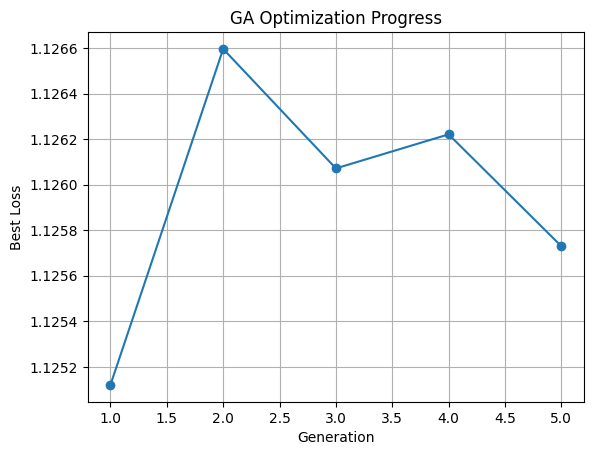


🏆 Best Hyperparameters: {'hidden_size': 32, 'bottleneck_size': 4, 'learning_rate': 0.05} with Loss: 1.1257


In [ ]:
from sklearn.model_selection import train_test_split

X_train_ga, X_val_ga = train_test_split(X_train, test_size=0.2, random_state=42)

# Run GA
best_params = run_ga(X_val_ga)

# Anomaly Detection using Reconstruction Error

In [ ]:

ae_best = Autoencoder(
    input_size=X_train.shape[1],
    hidden_size=best_params["hidden_size"],
    bottleneck_size=best_params["bottleneck_size"],
    learning_rate=best_params["learning_rate"]
)
ae_best.train(X_train, epochs=50)


reconstruction_error = ae_best.get_reconstruction_error(X_test)
threshold = np.percentile(reconstruction_error, 95)
y_pred = (reconstruction_error > threshold).astype(int)

Epoch 1, Loss: 1.214503
Epoch 10, Loss: 1.116458
Epoch 20, Loss: 1.058627
Epoch 30, Loss: 1.028207
Epoch 40, Loss: 1.010827
Epoch 50, Loss: 1.000060


# Metrics & Visualization

Classification Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))

Accuracy : 0.951353533934904
Precision: 0.03088803088803089
Recall   : 0.8979591836734694
F1 Score : 0.05972175093315236


Visualize Reconstruction Error

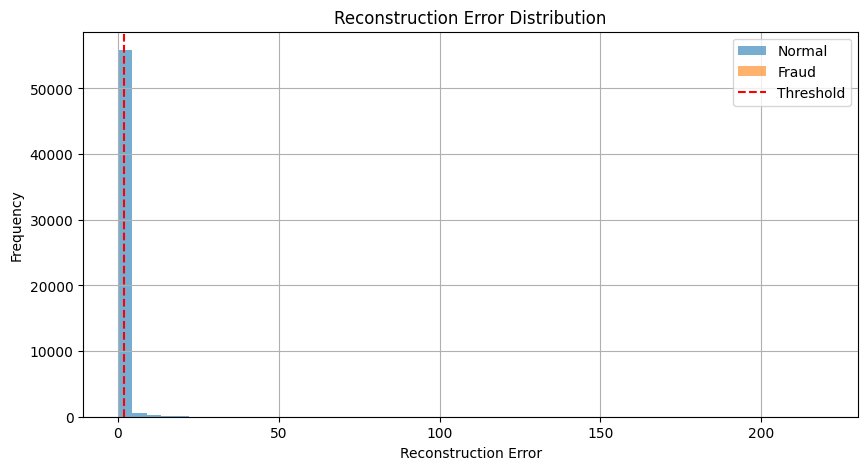

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_error[y_test == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(reconstruction_error[y_test == 1], bins=50, alpha=0.6, label='Fraud')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("Number of fraud samples in y_test:", np.sum(y_test))

Number of fraud samples in y_test: 98


NSL-KDD Dataset:

# Load & Preprocessing NSL-KDD Dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


df_train = pd.read_csv("/KDDTrain+.txt", header=None)
df_test = pd.read_csv("/KDDTest+.txt", header=None)


columns = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment',
    'urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted',
    'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds',
    'is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
    'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
    'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
    'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','label','difficulty_level'
]

df_train.columns = columns
df_test.columns = columns


df_train['label'] = df_train['label'].apply(lambda x: 0 if x == 'normal' else 1)
df_test['label'] = df_test['label'].apply(lambda x: 0 if x == 'normal' else 1)


combined_df = pd.concat([df_train, df_test])
categorical_cols = ['protocol_type', 'service', 'flag']

for col in categorical_cols:
    encoder = LabelEncoder()
    combined_df[col] = encoder.fit_transform(combined_df[col])


df_train = combined_df.iloc[:len(df_train)]
df_test = combined_df.iloc[len(df_train):]


X_train = df_train.drop(columns=['label']).values
y_train = df_train['label'].values

X_test = df_test.drop(columns=['label']).values
y_test = df_test['label'].values


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


X_train_normal = X_train[y_train == 0]

# Autoencoder

In [ ]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    sx = sigmoid(x)
    return sx * (1 - sx)

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

class Autoencoder:
    def __init__(self, input_size, hidden_size, bottleneck_size, learning_rate=0.01):
        self.lr = learning_rate

        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))

        self.W2 = np.random.randn(hidden_size, bottleneck_size) * 0.01
        self.b2 = np.zeros((1, bottleneck_size))

        self.W3 = np.random.randn(bottleneck_size, hidden_size) * 0.01
        self.b3 = np.zeros((1, hidden_size))

        self.W4 = np.random.randn(hidden_size, input_size) * 0.01
        self.b4 = np.zeros((1, input_size))

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = sigmoid(self.z1)

        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = sigmoid(self.z2)

        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = sigmoid(self.z3)

        self.z4 = np.dot(self.a3, self.W4) + self.b4
        self.output = sigmoid(self.z4)

        return self.output

    def backward(self, X):
        m = X.shape[0]
        error = self.output - X
        d_output = error * sigmoid_derivative(self.z4)

        dW4 = np.dot(self.a3.T, d_output) / m
        db4 = np.sum(d_output, axis=0, keepdims=True) / m

        d_a3 = np.dot(d_output, self.W4.T) * sigmoid_derivative(self.z3)
        dW3 = np.dot(self.a2.T, d_a3) / m
        db3 = np.sum(d_a3, axis=0, keepdims=True) / m

        d_a2 = np.dot(d_a3, self.W3.T) * sigmoid_derivative(self.z2)
        dW2 = np.dot(self.a1.T, d_a2) / m
        db2 = np.sum(d_a2, axis=0, keepdims=True) / m

        d_a1 = np.dot(d_a2, self.W2.T) * sigmoid_derivative(self.z1)
        dW1 = np.dot(X.T, d_a1) / m
        db1 = np.sum(d_a1, axis=0, keepdims=True) / m

        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4
        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def train(self, X, epochs=50):
        for epoch in range(epochs):
            self.forward(X)
            loss = mse(X, self.output)
            self.backward(X)
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}, Loss: {loss:.6f}")

    def get_reconstruction_error(self, X):
        out = self.forward(X)
        return np.mean((X - out) ** 2, axis=1)

# Genetic Algorithm

In [ ]:
import random
import matplotlib.pyplot as plt


param_ranges = {
    "hidden_size": [8, 16, 32],
    "bottleneck_size": [4, 8, 16],
    "learning_rate": [0.001, 0.005, 0.01, 0.05]
}

def create_individual():
    return {
        "hidden_size": random.choice(param_ranges["hidden_size"]),
        "bottleneck_size": random.choice(param_ranges["bottleneck_size"]),
        "learning_rate": random.choice(param_ranges["learning_rate"])
    }

def evaluate_individual(individual, X_val):
    ae = Autoencoder(
        input_size=X_val.shape[1],
        hidden_size=individual["hidden_size"],
        bottleneck_size=individual["bottleneck_size"],
        learning_rate=individual["learning_rate"]
    )
    ae.train(X_val, epochs=10)
    loss = np.mean(ae.get_reconstruction_error(X_val))
    return loss

In [ ]:
def crossover(parent1, parent2):
    return {
        key: random.choice([parent1[key], parent2[key]]) for key in parent1
    }

def mutate(individual, mutation_rate=0.1):
    for key in individual:
        if random.random() < mutation_rate:
            individual[key] = random.choice(param_ranges[key])
    return individual

def run_ga(X_val, population_size=6, generations=5):
    population = [create_individual() for _ in range(population_size)]
    best_losses = []

    for generation in range(generations):
        print(f"\n🔄 Generation {generation+1}")
        fitness_scores = []
        for individual in population:
            loss = evaluate_individual(individual, X_val)
            fitness_scores.append((loss, individual))
            print(f"{individual} ➤ Loss: {loss:.4f}")

        fitness_scores.sort(key=lambda x: x[0])
        best_losses.append(fitness_scores[0][0])

        top_individuals = [ind for _, ind in fitness_scores[:population_size//2]]

        new_population = top_individuals[:]
        while len(new_population) < population_size:
            parents = random.sample(top_individuals, 2)
            child = crossover(parents[0], parents[1])
            child = mutate(child)
            new_population.append(child)

        population = new_population


    plt.plot(range(1, generations + 1), best_losses, marker='o')
    plt.title("GA Optimization Progress")
    plt.xlabel("Generation")
    plt.ylabel("Best Loss")
    plt.grid(True)
    plt.show()

    best_loss, best_individual = min(fitness_scores, key=lambda x: x[0])
    print(f"\n🏆 Best Hyperparameters: {best_individual} with Loss: {best_loss:.4f}")
    return best_individual


🔄 Generation 1
Epoch 1, Loss: 1.293336
Epoch 10, Loss: 1.148229
{'hidden_size': 32, 'bottleneck_size': 4, 'learning_rate': 0.05} ➤ Loss: 1.1377
Epoch 1, Loss: 1.296243
Epoch 10, Loss: 1.235549
{'hidden_size': 8, 'bottleneck_size': 16, 'learning_rate': 0.05} ➤ Loss: 1.2293
Epoch 1, Loss: 1.295616
Epoch 10, Loss: 1.148655
{'hidden_size': 32, 'bottleneck_size': 8, 'learning_rate': 0.05} ➤ Loss: 1.1379
Epoch 1, Loss: 1.295735
Epoch 10, Loss: 1.276669
{'hidden_size': 32, 'bottleneck_size': 4, 'learning_rate': 0.005} ➤ Loss: 1.2746
Epoch 1, Loss: 1.295340
Epoch 10, Loss: 1.202015
{'hidden_size': 16, 'bottleneck_size': 4, 'learning_rate': 0.05} ➤ Loss: 1.1935
Epoch 1, Loss: 1.296128
Epoch 10, Loss: 1.292253
{'hidden_size': 32, 'bottleneck_size': 16, 'learning_rate': 0.001} ➤ Loss: 1.2918

🔄 Generation 2
Epoch 1, Loss: 1.294305
Epoch 10, Loss: 1.148668
{'hidden_size': 32, 'bottleneck_size': 4, 'learning_rate': 0.05} ➤ Loss: 1.1381
Epoch 1, Loss: 1.293393
Epoch 10, Loss: 1.147355
{'hidden_size

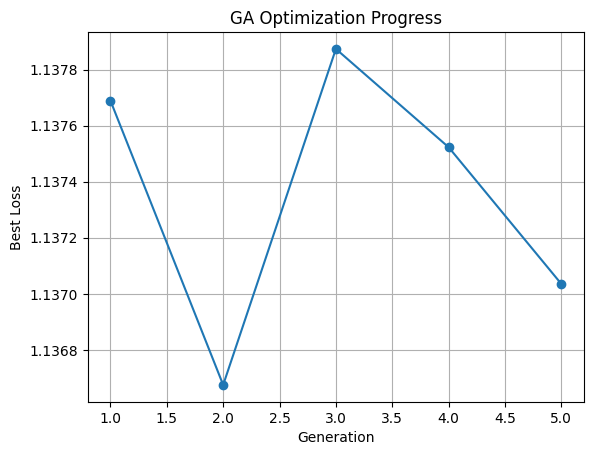


🏆 Best Hyperparameters: {'hidden_size': 32, 'bottleneck_size': 8, 'learning_rate': 0.05} with Loss: 1.1370


In [ ]:
X_train_ga, X_val_ga = train_test_split(X_train_normal, test_size=0.2, random_state=42)
best_params = run_ga(X_val_ga)

# Training the best autoencoder

In [ ]:
ae_best = Autoencoder(
    input_size=X_train_normal.shape[1],
    hidden_size=best_params["hidden_size"],
    bottleneck_size=best_params["bottleneck_size"],
    learning_rate=best_params["learning_rate"]
)
ae_best.train(X_train_normal, epochs=50)

Epoch 1, Loss: 1.135503
Epoch 10, Loss: 0.988790
Epoch 20, Loss: 0.911527
Epoch 30, Loss: 0.874094
Epoch 40, Loss: 0.853676
Epoch 50, Loss: 0.841398


# Detecting Anomalies

In [ ]:
reconstruction_error = ae_best.get_reconstruction_error(X_test)
threshold = np.percentile(reconstruction_error, 95)
y_pred = (reconstruction_error > threshold).astype(int)

# Evaluation

              precision    recall  f1-score   support

      Normal       0.45      0.99      0.62      9711
      Attack       0.90      0.08      0.15     12833

    accuracy                           0.47     22544
   macro avg       0.68      0.53      0.38     22544
weighted avg       0.71      0.47      0.35     22544



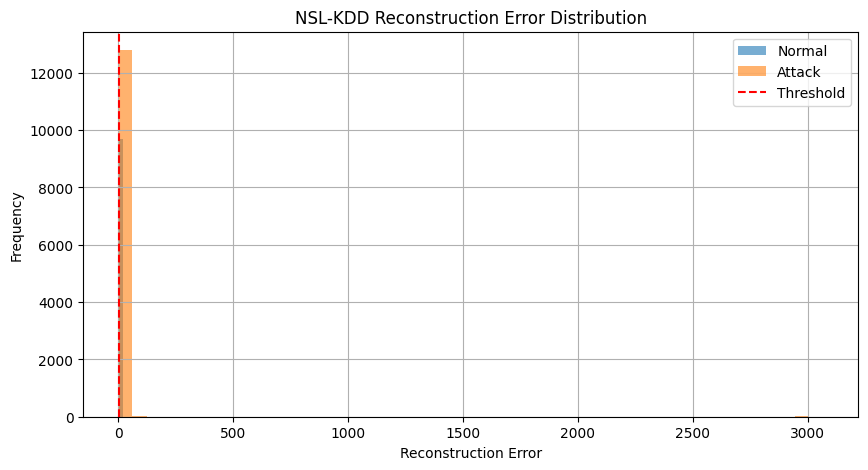

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=["Normal", "Attack"]))


normal_errors = reconstruction_error[y_test == 0]
attack_errors = reconstruction_error[y_test == 1]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(normal_errors, bins=50, alpha=0.6, label='Normal')
plt.hist(attack_errors, bins=50, alpha=0.6, label='Attack')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("NSL-KDD Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()